#Run Simulation

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

confirmed_cases_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
confirmed_cases = pd.read_csv(confirmed_cases_url, sep=',')
deaths_url =  'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
deaths = pd.read_csv(deaths_url, sep=',')

In [0]:
import pymc3 as pm
import theano.tensor as tt
import theano
import datetime
import time

data_end = '3/20/20' #Take the data until yesterday
data_begin = '3/6/20'
num_days_to_predict = 28

cases_obs = np.array(
    confirmed_cases.loc[confirmed_cases["Country/Region"] == "Germany", data_begin:data_end]
)[0]
date_data_end = confirmed_cases.loc[confirmed_cases["Country/Region"] == "Germany", data_begin:data_end].columns[-1]
month, day, year = map(int,date_data_end.split('/'))
date_data_end = datetime.date(year+2000, month, day)
date_today = date_data_end + datetime.timedelta(days=1)
print('Cases yesterday ({}): {} and day before yesterday: {}'.format(date_data_end.isoformat(), *cases_obs[:-3:-1]))
deaths_obs = np.array(deaths.loc[deaths["Country/Region"] == "Germany", data_begin:data_end])[0]
num_days = len(cases_obs)
np.random.seed(0)

# ------------------------------------------------------------------------------ #
# model setup and training
# ------------------------------------------------------------------------------ #

def SIR_model(λ, μ, S_begin, I_begin, N):
    new_I_0 = tt.zeros_like(I_begin)
    def next_day(λ, S_t, I_t, _):
        new_I_t = λ/N*I_t*S_t
        S_t = S_t - new_I_t
        I_t = I_t + new_I_t - μ * I_t
        return S_t, I_t, new_I_t
    outputs , _  = theano.scan(fn=next_day, sequences=[λ], 
                               outputs_info=[S_begin, I_begin, new_I_0])
    S_all, I_all, new_I_all = outputs
    return S_all, I_all, new_I_all

with pm.Model() as model:
    # true cases at begin of loaded data but we do not know the real number
    I_begin = pm.Lognormal("I_begin", mu=np.log(cases_obs[0]), sigma=0.9)

    # fraction of people that are newly infected each day
    λ = pm.Lognormal("λ", mu=np.log(0.4), sigma=0.5)

    # fraction of people that recover each day, recovery rate mu
    μ = pm.Lognormal('μ', mu=np.log(1/8), sigma=0.2)

    # prior of the error of observed cases
    σ_obs = pm.HalfCauchy("σ_obs", beta=1)

    N_germany = 83e6

    # -------------------------------------------------------------------------- #
    # training the model with loaded data
    # -------------------------------------------------------------------------- #

    S_begin = N_germany - I_begin
    S_past, I_past, new_I_past = SIR_model(λ=λ * tt.ones(num_days-1), μ=μ, 
                                               S_begin=S_begin, I_begin=I_begin,
                                               N=N_germany)
    new_infections_obs = np.diff(cases_obs)

    # Approximates Poisson
    # calculate the likelihood of the model:
    # observed cases are distributed following studentT around the model
    pm.StudentT(
        "obs",
        nu=4,
        mu=new_I_past,
        sigma=new_I_past ** 0.5 * σ_obs,
        observed=new_infections_obs
        )  
    
    S_past = pm.Deterministic('S_past', S_past)
    I_past = pm.Deterministic('I_past', I_past)
    new_I_past = pm.Deterministic('new_I_past', new_I_past)

    # -------------------------------------------------------------------------- #
    # prediction, start with no changes in policy
    # -------------------------------------------------------------------------- #
    
    # delay in days between contracting the disease and being recorded
    delay = pm.Lognormal("delay", mu=np.log(8), sigma=0.1)

    # local copy of original fitted values

    S_begin = S_past[-1]
    I_begin = I_past[-1]
    forecast_no_change = SIR_model(λ=λ*tt.ones(num_days_to_predict), μ=μ, 
                        S_begin=S_begin, I_begin=I_begin, N=N_germany)
    S_no_change, I_no_change, new_I_no_change = forecast_no_change

    #saves the variables for later retrieval
    pm.Deterministic('S_no_change', S_no_change)
    pm.Deterministic('I_no_change', I_no_change)
    pm.Deterministic('new_I_no_change', new_I_no_change)

    # -------------------------------------------------------------------------- #
    # social distancing, m reduced by about 50 percent
    # -------------------------------------------------------------------------- #
    #For all following predictions:
    length_transient = 7  # days


    # λ is decreased by 50%
    reduc_factor_mild = 0.5
    days_offset = 0  # start the decrease in spreading rate after this

    time_arr = np.arange(num_days_to_predict)

    # change in m along time
    λ_correction = tt.clip((time_arr - delay - days_offset + 1) / length_transient, 0, 1)
    λ_t_soc_dist= λ * (1 - λ_correction * reduc_factor_mild) 

    S_begin = S_past[-1]
    I_begin = I_past[-1]
    forecast_soc_dist = SIR_model(λ=λ_t_soc_dist, μ=μ, 
                        S_begin=S_begin, I_begin=I_begin, 
                        N=N_germany)
    S_soc_dist, I_soc_dist, new_I_soc_dist = forecast_soc_dist
    pm.Deterministic('S_soc_dist', S_soc_dist)
    pm.Deterministic('I_soc_dist', I_soc_dist)
    pm.Deterministic('new_I_soc_dist', new_I_soc_dist)

    # -------------------------------------------------------------------------- #
    # isolation, almost no new infections besides baseline after transient phase
    # -------------------------------------------------------------------------- #

    # λ is decreased by 90%
    reduc_factor_strong = 0.9
    days_offset = 0  # start the decrease in spreading rate after this

    # spreading of people who transmit although they are isolated
    time_arr = np.arange(num_days_to_predict)

    # change in λ along time
    λ_correction = tt.clip((time_arr - delay - days_offset+1) / length_transient, 0, 1)
    λ_t_isol= λ * (1 - λ_correction * reduc_factor_strong)

    S_begin = S_past[-1]
    I_begin = I_past[-1]
    forecast_isol = SIR_model(λ=λ_t_isol , μ=μ, 
                              S_begin=S_begin, I_begin=I_begin, 
                              N=N_germany)
    S_isol, I_isol, new_I_isol = forecast_isol

    pm.Deterministic('S_isol', S_isol)
    pm.Deterministic('I_isol', I_isol)  
    pm.Deterministic('new_I_isol', new_I_isol)

    # -------------------------------------------------------------------------- #
    # isolation 5 days later, almost no new infections besides baseline after transient phase
    # -------------------------------------------------------------------------- #

    # λ is decreased by 90%
    reduc_factor_strong = 0.9
    days_offset = 5  # start the decrease in spreading rate after this

    # spreading of people who transmit although they are isolated
    time_arr = np.arange(num_days_to_predict)

    # change in λ along time
    λ_correction = tt.clip((time_arr - delay - days_offset+1) / length_transient, 0, 1)
    λ_t_isol_later= λ * (1 - λ_correction * reduc_factor_strong) 
    λ_t_isol_later = tt.nnet.nnet.relu(λ_t_isol_later)


    S_begin = S_past[-1]
    I_S_beginbegin = I_past[-1]
    forecast_isol_later = SIR_model(λ=λ_t_isol_later, μ=μ, 
                         S_begin=S_begin, I_begin=I_begin, 
                         N=N_germany)
    S_isol_later, I_isol_later, new_I_isol_later = forecast_isol_later

    pm.Deterministic('S_isol_later', S_isol_later)
    pm.Deterministic('I_isol_later', I_isol_later)  
    pm.Deterministic('new_I_isol_later', new_I_isol_later)

    # -------------------------------------------------------------------------- #
    # run model, pm trains and predicts when calling this
    # -------------------------------------------------------------------------- #

    time_beg = time.time()
    trace = pm.sample(draws=500, tune=800, chains=2)
    print("Model run in {:.2f} s".format(time.time() - time_beg))

Cases yesterday (2020-03-20): 19848 and day before yesterday: 15320


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [delay, σ_obs, μ, λ, I_begin]
100%|██████████| 1300/1300 [00:26<00:00, 49.93it/s]


Model run in 120.07 s


#Plotting 

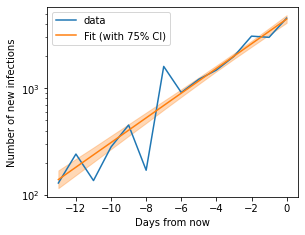

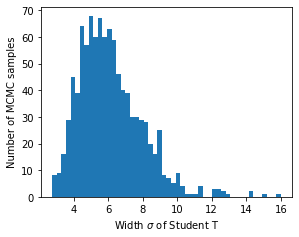

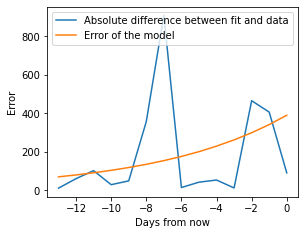

In [0]:
time = np.arange(-len(cases_obs)+2, 1)
plt.figure(figsize=(4.5,3.5))
plt.plot(time, np.diff(cases_obs), label='data')
percentiles = np.percentile(trace.new_I_past, q=12.5, axis=0), np.percentile(trace.new_I_past, q=87.5, axis=0)
plt.plot(time, np.median(trace.new_I_past, axis=0),color='tab:orange', label='Fit (with 75% CI)')
#print(percentiles)
plt.fill_between(time, percentiles[0], percentiles[1], alpha=0.3, color='tab:orange')
plt.yscale('log')
plt.ylabel('Number of new infections')
plt.xlabel('Days from now')
plt.legend()

#print(trace.new_I_past[-1])
#print(trace.new_I_isol[-1])
#print(trace.new_I_no_change[-1])
plt.figure(figsize=(4.5,3.5))
plt.hist(trace.σ_obs, bins=50)
plt.ylabel('Number of MCMC samples')
plt.xlabel('Width $\sigma$ of Student T')

plt.figure(figsize=(4.5,3.5))
plt.plot(time, np.abs(np.median(trace.new_I_past, axis=0) - np.diff(cases_obs)),
         label='Absolute difference between fit and data')
plt.plot(time, np.sqrt(np.median(trace.new_I_past, axis=0))*np.median(trace.σ_obs, axis=0),
         label='Error of the model')
plt.ylabel('Error')
plt.xlabel('Days from now')
plt.legend(loc='upper left')


array([  20204.42848489,   27092.4040388 ,   36327.14508307,
         48707.05431286,   65301.24386242,   87540.59050268,
        117338.83322749,  157253.15705865,  207351.78068287,
        266428.13733683,  333359.72483992,  405876.20102742,
        480506.4059706 ,  552712.46884435,  617240.47558681,
        681680.57149031,  752574.14950396,  830506.93770879,
        916104.4049148 , 1010031.36011664, 1112990.66357593,
       1225720.83212345, 1348992.29106966, 1483601.99557861,
       1630366.11756931, 1790110.47297926, 1963658.35224159,
       2151815.41873126])

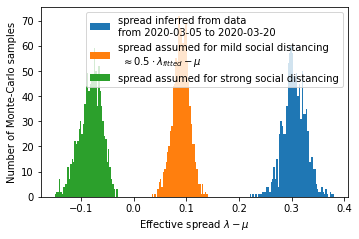

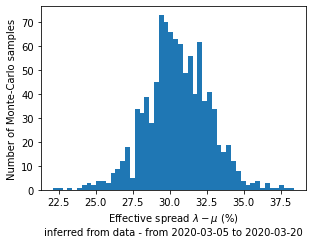

In [0]:
import matplotlib

day_begin = date_data_end - datetime.timedelta(days = num_days)

plt.figure(figsize=(5.5,3.5))
bins = np.linspace(-0.15, 0.38, 200)
plt.hist(trace.λ - trace.μ, bins=bins, 
         label='spread inferred from data\nfrom {} to {}'.format(day_begin.isoformat(), date_data_end.isoformat()))
plt.hist(np.maximum(trace.λ*(1-reduc_factor_mild) ,0) - trace.μ, bins=bins,
         label='spread assumed for mild social distancing\n $\\approx 0.5 \\cdot \\lambda_{fitted} - \mu $')
plt.hist(np.maximum(trace.λ*(1-reduc_factor_strong),0) - trace.μ, bins=bins, 
         label='spread assumed for strong social distancing')
plt.xlabel('Effective spread $\lambda - \mu$')
plt.ylabel('Number of Monte-Carlo samples')
plt.legend()
plt.savefig('Distributions_of_m.png', dpi=200)

plt.figure(figsize=(4.5,3.5))
#bins = np.linspace(-0.11, 0.304, 200)
plt.hist((trace.λ - trace.μ)*100, bins=50)
plt.xlabel('Effective spread $\lambda - \mu$ (%)\ninferred from data - from {} to {}'.format(day_begin.isoformat(), date_data_end.isoformat()))
plt.ylabel('Number of Monte-Carlo samples')
plt.tight_layout()
plt.savefig('Distributions_of_fitted_m.png', dpi=200)
trace.I_soc_dist[-1]

effective m: 1.304 +- 0.022


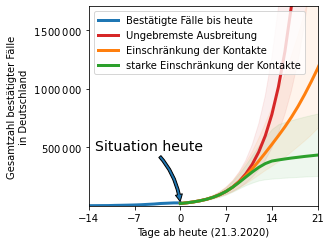

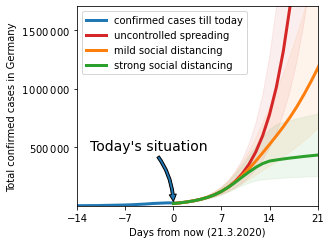

In [0]:
legends_lang = {'german': ['Bestätigte Fälle bis heute', ['Ungebremste Ausbreitung', 
           'Einschränkung der Kontakte', 'starke Einschränkung der Kontakte'],
                           'Tage ab heute ({}.{}.{})'.format(date_today.day, date_today.month, date_today.year),
                           'Gesamtzahl bestätigter Fälle\nin Deutschland',
                           "Situation heute"],
            'english': ['confirmed cases till today',['uncontrolled spreading', 'mild social distancing',
                                                          'strong social distancing'],
                            'Days from now ({}.{}.{})'.format(date_today.day, date_today.month, date_today.year),
                            'Total confirmed cases in Germany',
                            "Today's situation"]}
obs_cases_labels = ['new_I_no_change', 'new_I_soc_dist', 
                    'new_I_isol', 'new_I_isol_later']
cases_obs_to_plot = np.array(confirmed_cases.loc[confirmed_cases['Country/Region'] == 'Germany', '2/25/20':])[0]

def return_obs_cases_future(trace):
  obs_cases_future = dict()
  for label in obs_cases_labels:
    obs_cases_future[label] = np.cumsum(trace[label], axis=1) + cases_obs[-1]
    obs_cases_future[label] = obs_cases_future[label].T
  return obs_cases_future

for lang, legends_list in legends_lang.items():
  plt.figure(figsize=(4.7,3.5))
  colors = ['tab:red', 'tab:orange', "tab:green"]
  time = np.arange(-len(cases_obs_to_plot)+1, 1)
  plt.plot(time, cases_obs_to_plot, label=legends_list[0], linewidth=3)
  dict_obsc_cases = return_obs_cases_future(trace)
  for label, color, legend in zip(obs_cases_labels, colors, legends_list[1]):
    time = np.arange(num_days_to_predict+1)
    cases = dict_obsc_cases[label]
    cases = np.concatenate([np.ones((1,cases.shape[1]))*cases_obs[-1], cases], axis=0)
    median = np.median(cases, axis=-1)
    percentiles = np.percentile(cases, q=2.5, axis=-1), np.percentile(cases, q=97.5, axis=-1)
    plt.plot(time, median, color, linewidth=3, label=legend)
    plt.fill_between(time, percentiles[0], percentiles[1], alpha=0.08, color = color)


  plt.xlim(-14, 21)
  plt.ylim(100, 1700_000)
  plt.yscale('linear')
  plt.xlabel(legends_list[2])
  plt.ylabel(legends_list[3])
  #plt.locator_params(axis='y', nbins=4)
  plt.legend(loc='upper left')
  plt.xticks([-14,-7,0,7,14,21])
  plt.locator_params(nbins=4, axis='y')
  func_format = lambda num, _: '${:,.0f}$'.format(num).replace(',','\,')
  plt.gca().yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(func_format))

  plt.gca().annotate(legends_list[4],
              xy=(0., 20_000), xycoords='data',
              xytext=(0.45, 0.4), textcoords='figure fraction',
              size=14, va="center", ha="center",
              arrowprops=dict(arrowstyle="simple",
                              connectionstyle="arc3,rad=-0.2"),
              )

  plt.tight_layout()
  plt.savefig('cumulative_corona_germany_{}.png'.format(lang), dpi=300)

print('effective m: {:.3f} +- {:.3f}'.format(1+np.median(trace.λ - trace.μ), np.std(trace.λ - trace.μ)))

# 

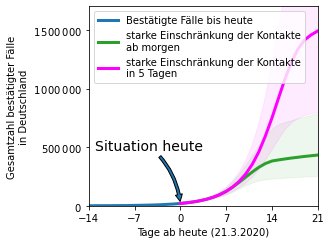

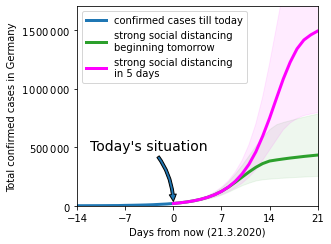

In [0]:

legends_lang = {'german': ['Bestätigte Fälle bis heute', ['starke Einschränkung der Kontakte\nab morgen', 
                           'starke Einschränkung der Kontakte\nin 5 Tagen'],
                           'Tage ab heute ({}.{}.{})'.format(date_today.day, date_today.month, date_today.year),
                           'Gesamtzahl bestätigter Fälle\nin Deutschland',
                           "Situation heute"],
                'english': ['confirmed cases till today',['strong social distancing\nbeginning tomorrow', 
                           'strong social distancing\nin 5 days'],
                            'Days from now ({}.{}.{})'.format(date_today.day, date_today.month, date_today.year),
                            'Total confirmed cases in Germany',
                            "Today's situation"]}
for lang, legends_list in legends_lang.items():
  plt.figure(figsize=(4.7,3.5))
  colors = ["tab:green", 'fuchsia']
  time = np.arange(-len(cases_obs)+1, 1)
  plt.plot(time, cases_obs, linewidth=3, label=legends_list[0])
  dict_obsc_cases = return_obs_cases_future(trace)
  for label, color, legend in zip(obs_cases_labels[2:], colors, legends_list[1]):
    time = np.arange(num_days_to_predict+1)
    cases = dict_obsc_cases[label]
    cases = np.concatenate([np.ones((1,cases.shape[1]))*cases_obs[-1], cases], axis=0)
    median = np.median(cases, axis=-1)
    percentiles = np.percentile(cases, q=2.5, axis=-1), np.percentile(cases, q=97.5, axis=-1)
    plt.plot(time, median, color, linewidth=3, label=legend)
    plt.fill_between(time, percentiles[0], percentiles[1], alpha=0.08, color = color)

  plt.xlim(-14, 21)
  plt.ylim(0, 1700000)
  plt.yscale('linear')
  plt.xlabel(legends_list[2])
  plt.ylabel(legends_list[3])
  plt.locator_params(axis='y', nbins=4)
  plt.legend(loc='upper left')
  plt.xticks([-14,-7,0,7,14,21])
  func_format = lambda num, _: '${:,.0f}$'.format(num).replace(',','\,')
  plt.gca().yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(func_format))

  plt.gca().annotate(legends_list[4],
              xy=(0., 20_000), xycoords='data',
              xytext=(0.45, 0.4), textcoords='figure fraction',
              size=14, va="center", ha="center",
              arrowprops=dict(arrowstyle="simple",
                              connectionstyle="arc3,rad=-0.2"),
              )

  plt.tight_layout()
  plt.savefig('cumulative_corona_germany_late_reaction_{}.png'.format(lang), dpi=300)
  #plt.savefig('cumulative_corona_germany_late_reaction_{}.pdf')

